In [15]:
import os
import imghdr #判断文件类型
from utils.im import *
import cv2 as cv
import numpy as np

In [16]:
# 截取人脸并保存
def facedetect(image, output):
    name = os.path.basename(image)
    image = cv.imread(image)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    detector = cv.CascadeClassifier('haarcascade_frontalface_alt2.xml')
    rects = detector.detectMultiScale(image,                  # 输入图片
                                      scaleFactor=1.1,        # 每次图像缩小的比例
                                      minNeighbors=3,        # 匹配成功所需要周围的矩形数目
                                      minSize=(10,10),        # 匹配人脸的最小范围10*10 px
                                      flags=cv.CASCADE_SCALE_IMAGE)
    for (x,y,w,h) in rects:
        f = cv.resize(image[y:y+h, x:x+w], (200,200)) #都转化为200*200固定大小
        cv.imwrite(os.path.join(output, name), f)

In [17]:
# 检测并截取人脸
def predictface(path, output):
    if not os.path.exists(output):
        os.makedirs(output)
    for im in os.listdir(path):
        file = os.path.join(path, im)
        facedetect(file, output)

In [18]:
predictface("./images/baby", "./images/clip/baby")

In [19]:
predictface("./images/xiaoming", "./images/clip/xiaoming")

In [20]:
# 生成标签
def generatelabel(path):
    f = open(os.path.join(path, 'label.txt'), 'w')
    label = 0
    for root, dirs, files in os.walk(path):
        for subdir in dirs:
            subdirPath = os.path.join(root, subdir)
            for file in os.listdir(subdirPath):
                filePath = os.path.join(subdirPath, file)
                imgType = imghdr.what(filePath)
                if imgType == 'jpeg' or imgType == 'png' or imgType == 'jpg':
                    f.write(filePath)
                    f.write(";")
                    f.write(str(label))
                    f.write("\n")
            label = label + 1
    f.close()

In [21]:
generatelabel("./images/clip")

In [22]:
# 训练自己的数据模型
images = []
labels = []

f = open("./images/clip/label.txt")
for line in f:
    item = line.split(";")
    img = cv.imread(item[0])
    images.append(img)
    labels.append(int(item[1]))
    
# 安装opencv扩展包
# pip install opencv-contrib-python
model = cv.face.EigenFaceRecognizer_create()
# model = cv.face.FinsherFaceRecognizer_create()
# model = cv.face.LBPHFaceRecognizer_create()
model.train(np.array(images), np.array(labels))
model.save("./images/clip/predict_face_xiaoming_AB.xml")

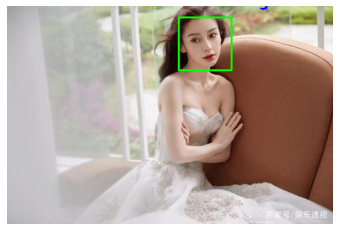

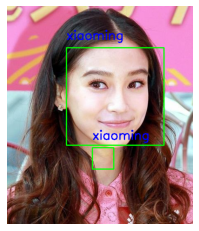

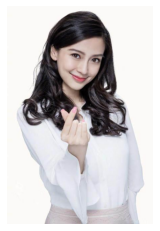

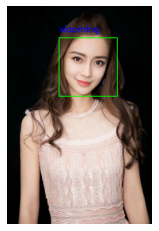

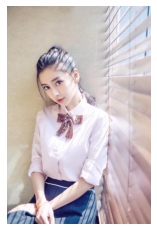

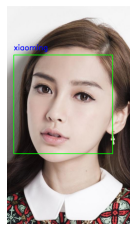

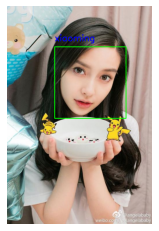

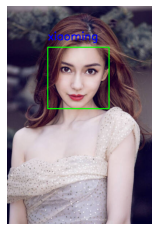

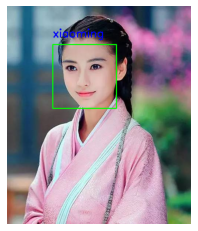

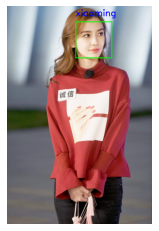

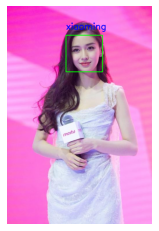

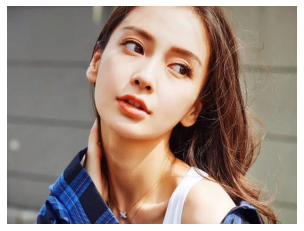

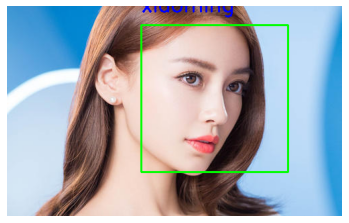

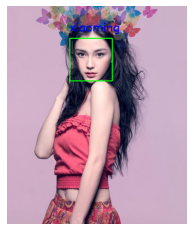

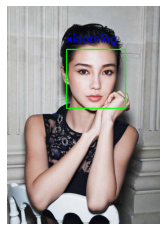

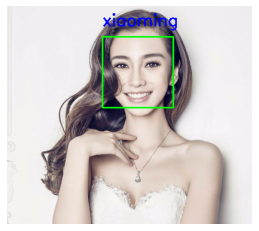

In [23]:
# 人脸识别
name = ['xiaoming', 'baby']
model = cv.face.EigenFaceRecognizer_create()
model.read("./images/clip/predict_face_xiaoming_AB.xml")

testpath = "./images/baby"
for file in os.listdir(testpath):
    file = os.path.join(testpath, file)
    imgType = imghdr.what(file)
    if imgType == 'jpeg' or imgType == 'png' or imgType == 'jpg':
        image = cv.imread(file)
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        detector = cv.CascadeClassifier('haarcascade_frontalface_alt2.xml')
        rects = detector.detectMultiScale(image,                  # 输入图片
                                          scaleFactor=1.1,        # 每次图像缩小的比例
                                          minNeighbors=3,        # 匹配成功所需要周围的矩形数目
                                          minSize=(10,10),        # 匹配人脸的最小范围10*10 px
                                          flags=cv.CASCADE_SCALE_IMAGE)
        for (x, y, w, h) in rects:
            cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            face = cv.resize(gray[y: y+h, x: x+w], (200, 200))
            params = model.predict(face)
            cv.putText(image, 
                       name[params[0]], 
                       (x, y - 20), 
                       cv.FONT_HERSHEY_SIMPLEX, 
                       1, 
                       (255, 0, 0), 
                       2)
        show(image)